## Train a model with Iris data using XGBoost algorithm
###  Model is trained with XGBoost installed in notebook instance
###  In the later examples, we will train using SageMaker's XGBoost algorithm

In [1]:
# Install xgboost in notebook instance.
#### Command to install xgboost
!pip install xgboost==0.90

     |████████████████████████████████| 142.8 MB 20.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/jmajumde/mypython3env/bin/python3 -m pip install --upgrade pip' command.


In [30]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing

In [109]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, make_scorer, SCORERS
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,VotingClassifier


In [3]:
column_list_file = 'iris_train_column_list.txt'
train_file = 'iris_train.csv'
validation_file = 'iris_validation.csv'

In [4]:
columns=[]
with open(column_list_file, 'r') as f:
    columns=f.read().split(',')
columns

['encoded_class', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [108]:
# encode class labels to integer
labels = [0,1,2]
classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
le = preprocessing.LabelEncoder()
le.fit(classes)

LabelEncoder()

In [10]:
# load df_train and df_validation 
# specify the column names 
df_train = pd.read_csv(train_file, names=columns)
df_validation = pd.read_csv(validation_file,names=columns)

print("***train summary****")
print(df_train.head())
print(df_train.shape)

print("\n\n**validation summary****")
print(df_validation.head())
print(df_validation.shape)

***train summary****
   encoded_class  sepal_length  sepal_width  petal_length  petal_width
0              1           5.8          2.7           3.9          1.2
1              2           6.1          2.6           5.6          1.4
2              2           5.8          2.8           5.1          2.4
3              0           4.4          3.2           1.3          0.2
4              2           7.2          3.6           6.1          2.5
(105, 5)


**validation summary****
   encoded_class  sepal_length  sepal_width  petal_length  petal_width
0              1           5.8          2.7           4.1          1.0
1              0           4.8          3.4           1.6          0.2
2              1           6.0          2.2           4.0          1.0
3              2           6.4          3.1           5.5          1.8
4              2           6.7          2.5           5.8          1.8
(45, 5)


In [51]:
# X, y split for train and validation dataset 
X_train = df_train.iloc[:,1:] # choose from 2nd column, col index stars from 0, here 0th col is the target/label
y_train = df_train.iloc[:,0].ravel() # to flatten into 1-D array

X_validation = df_validation.iloc[:,1:]
y_validation = df_validation.iloc[:,0].ravel() 

print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

(105, 4) (105,)
(45, 4) (45,)


In [47]:
# Using XGB
# with predefined hyperparameter's to find the base model

myXgb = xgb.XGBClassifier(verbosity=2, num_class=3, n_estimators=100)
myXgb.fit(X_train, y_train)
myXgb

[08:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[08:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[08:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[08:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[08:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[08:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[08:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[08:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pr

XGBClassifier(num_class=3, objective='multi:softprob', verbosity=2)

In [58]:
print(myXgb.score(X_train, y_train))
print(myXgb.score(X_validation, y_validation))

1.0
0.9555555555555556


In [52]:
myXgb.predict_proba(X_validation)[:10]

array([[0.00530294, 0.99138343, 0.00331354],
       [0.9884213 , 0.00904817, 0.00253053],
       [0.01280441, 0.97076124, 0.01643432],
       [0.00252959, 0.00530877, 0.9921617 ],
       [0.00213319, 0.00568144, 0.9921854 ],
       [0.00296416, 0.00679379, 0.99024206],
       [0.00315151, 0.00985099, 0.9869975 ],
       [0.9884213 , 0.00904817, 0.00253053],
       [0.9884213 , 0.00904817, 0.00253053],
       [0.01093473, 0.01996672, 0.9690985 ]], dtype=float32)

In [56]:
# tune the optimal number of trees 
tree_range = range(2,50,5)
train_score=[]
valid_score=[]
for tree in tree_range:
    model = xgb.XGBClassifier(n_estimators=tree, objective='multi:softmax')
    model.fit(X_train, y_train)
    train_score.append(model.score(X_train, y_train))
    valid_score.append(model.score(X_validation, y_validation))


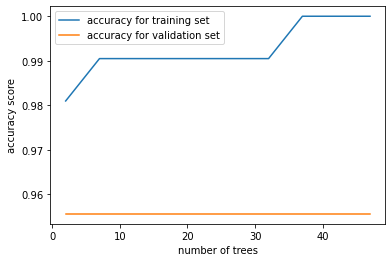

In [60]:
plt.plot(tree_range, train_score, label="accuracy for training set")
plt.plot(tree_range, valid_score, label="accuracy for validation set")
plt.xlabel('number of trees')
plt.ylabel('accuracy score')
plt.legend()
plt.show()

Here it shows any number of trees the model performs extremely well. The accuracy starts from 98% to reaches to 100% when we increase the number of trees. 

In [70]:
# valid scorers
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [76]:
# perform hyperparameter tuning using GridSearchCV
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=4)


param_grid = {
    "max_depth" : range(1,5,1),
    #"subsample": [0.4, 0.7, 0.9],
    "alpha" : [1e-5, 1e-2, 0.05, 0.003, 0.2],
    "n_estimators" : range(2,10,1)
}

# define make_scorer callable for multiclass classification in GridSearchCV as it does not support 
# multiclass classification 
my_scorer = make_scorer(roc_auc_score, multiclass='ovr') # one over many 

myXgb = xgb.XGBClassifier()
myXgbCv = GridSearchCV(estimator=myXgb, param_grid=param_grid, cv=folds, 
                       scoring='accuracy', return_train_score=True,
                      verbose=3, n_jobs=-1)
myXgbCv.fit(X_train, y_train)


Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s


AttributeError: 'NoneType' object has no attribute 'save_config'

In [77]:
subsample=[0.4, 0.7, 0.9]
train_score=[]
valid_score=[]
for x in subsample:
    model = xgb.XGBClassifier(n_estimators=10, subsample=x, num_class=3, 
                              objective="multi:softmax", max_depth=4)
    model.fit(X_train, y_train)
    train_score.append(model.score(X_train, y_train))
    valid_score.append(model.score(X_validation, y_validation))
    
    

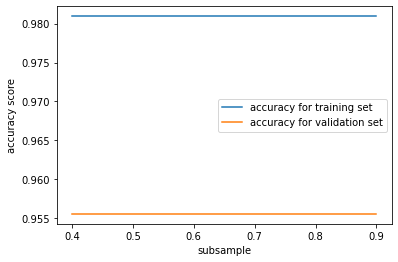

In [79]:
plt.plot(subsample, train_score, label="accuracy for training set")
plt.plot(subsample, valid_score, label="accuracy for validation set")
plt.xlabel('subsample')
plt.ylabel('accuracy score')
plt.legend()
plt.show()

In [86]:
myXgb = xgb.XGBClassifier(n_estimators=50, subsample=0.7, num_class=3, 
                              objective="multi:softmax", max_depth=4)
myXgb.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_validation,y_validation)]
          ,eval_metric=['mlogloss'],early_stopping_rounds=10)
# early_stopping_rounds - needs to be passed in as a hyperparameter in SageMaker XGBoost implementation
# "The model trains until the validation score stops improving. 
# Validation error needs to decrease at least every early_stopping_rounds to continue training.
# Amazon SageMaker hosting uses the best model for inference."        

[0]	validation_0-mlogloss:0.972158	validation_1-mlogloss:0.974918
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:0.865759	validation_1-mlogloss:0.871113
[2]	validation_0-mlogloss:0.775156	validation_1-mlogloss:0.78291
[3]	validation_0-mlogloss:0.697477	validation_1-mlogloss:0.706081
[4]	validation_0-mlogloss:0.632244	validation_1-mlogloss:0.64026
[5]	validation_0-mlogloss:0.573294	validation_1-mlogloss:0.582296
[6]	validation_0-mlogloss:0.520837	validation_1-mlogloss:0.530959
[7]	validation_0-mlogloss:0.475092	validation_1-mlogloss:0.483989
[8]	validation_0-mlogloss:0.433004	validation_1-mlogloss:0.445951
[9]	validation_0-mlogloss:0.395807	validation_1-mlogloss:0.411817
[10]	validation_0-mlogloss:0.363005	validation_1-mlogloss:0.383089
[11]	validation_0-mlogloss:0.333303	validation_1-mlogloss:0.355442
[12]	validation_0-mlogloss:0.305582	valid

XGBClassifier(max_depth=4, n_estimators=50, num_class=3,
              objective='multi:softprob', subsample=0.7)

In [91]:
myXgb.evals_result_


{'validation_0': {'mlogloss': [0.972158,
   0.865759,
   0.775156,
   0.697477,
   0.632244,
   0.573294,
   0.520837,
   0.475092,
   0.433004,
   0.395807,
   0.363005,
   0.333303,
   0.305582,
   0.282832,
   0.261721,
   0.24297,
   0.22542,
   0.20944,
   0.19547,
   0.182259,
   0.169964,
   0.159088,
   0.148444,
   0.139345,
   0.131241,
   0.123222,
   0.116917,
   0.110058,
   0.104295,
   0.099015,
   0.094234,
   0.089271,
   0.08526,
   0.081305,
   0.077633,
   0.074394,
   0.071171,
   0.068342,
   0.065596,
   0.062959,
   0.06071,
   0.058575,
   0.05618,
   0.054716,
   0.05343,
   0.052063,
   0.05062,
   0.049255,
   0.047955,
   0.046782]},
 'validation_1': {'mlogloss': [0.974918,
   0.871113,
   0.78291,
   0.706081,
   0.64026,
   0.582296,
   0.530959,
   0.483989,
   0.445951,
   0.411817,
   0.383089,
   0.355442,
   0.331439,
   0.310544,
   0.289625,
   0.273651,
   0.257523,
   0.243195,
   0.232816,
   0.222663,
   0.214925,
   0.2055,
   0.197376,
   0.1

In [94]:
eval_result=myXgb.evals_result()
training_rounds = range(len(eval_result['validation_0']['mlogloss']))
print(training_rounds)

range(0, 50)


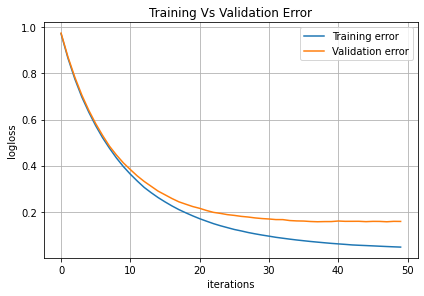

In [95]:
plt.plot(training_rounds, eval_result['validation_0']['mlogloss'], label="Training error")
plt.plot(training_rounds, eval_result['validation_1']['mlogloss'], label="Validation error")
plt.grid(True)
plt.xlabel('iterations')
plt.ylabel('logloss')
plt.tight_layout()
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

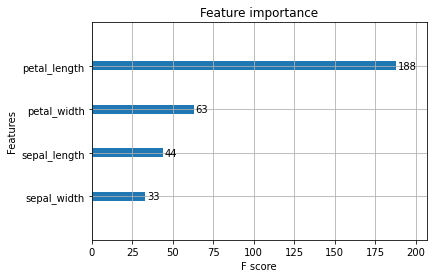

In [96]:
xgb.plot_importance(myXgb)
plt.show()

In [97]:
# prediction 

In [98]:
# read validation data set and predict 
pred_df = pd.read_csv(validation_file, names=columns)
pred_df.head()

,encoded_class,sepal_length,sepal_width,petal_length,petal_width
0,1,5.8,2.7,4.1,1.0
1,0,4.8,3.4,1.6,0.2
2,1,6.0,2.2,4.0,1.0
3,2,6.4,3.1,5.5,1.8
4,2,6.7,2.5,5.8,1.8


In [99]:
X_test = pred_df.iloc[:,1:]
res = myXgb.predict(X_test)
res[:10]

array([1, 0, 1, 2, 2, 2, 2, 0, 0, 2])

In [112]:
y_test = pred_df.iloc[:,0]
y_test[:5]

0    1
1    0
2    1
3    2
4    2
Name: encoded_class, dtype: int64

In [100]:
pred_df['predicted_class'] = res
#pred_df['predicted_class_name'] = le.inverse_transform(result)
pred_df.head()

,encoded_class,sepal_length,sepal_width,petal_length,petal_width,predicted_class
0,1,5.8,2.7,4.1,1.0,1
1,0,4.8,3.4,1.6,0.2,0
2,1,6.0,2.2,4.0,1.0,1
3,2,6.4,3.1,5.5,1.8,2
4,2,6.7,2.5,5.8,1.8,2


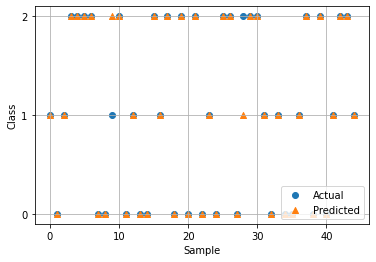

In [107]:
# plot the actual class label v/s predicted class label
plt.scatter(pred_df.index,pred_df['encoded_class'], label='Actual')
plt.scatter(pred_df.index,pred_df['predicted_class'], label='Predicted', marker='^')
plt.grid(True)
plt.xlabel('Sample')
plt.ylabel('Class')
plt.legend(loc=4)
plt.yticks([0,1,2])
plt.show()

<h2>Confusion Matrix</h2>
Confusion Matrix is a table that summarizes performance of classification model.<br><br>

In [115]:
cnf_mtrx = confusion_matrix(pred_df['encoded_class'], pred_df['predicted_class'], labels=labels)
cnf_mtrx

array([[16,  0,  0],
       [ 0, 10,  1],
       [ 0,  1, 17]])

In [110]:
from sklearn.metrics import ConfusionMatrixDisplay

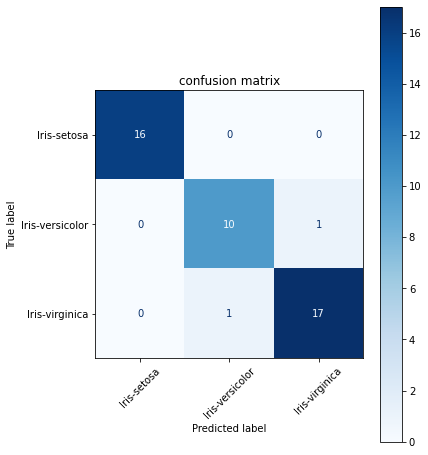

In [133]:
# plot both normalized and non-normalized confusion matrix
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(111)
ax.set_title("confusion matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mtrx)
disp.plot(ax=ax, cmap=plt.cm.Blues)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.show()


    

In [136]:
# print classification report 
print(classification_report(pred_df['encoded_class'],
                           pred_df['predicted_class'],
                           labels=labels,
                           target_names = classes))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        16
Iris-versicolor       0.91      0.91      0.91        11
 Iris-virginica       0.94      0.94      0.94        18

       accuracy                           0.96        45
      macro avg       0.95      0.95      0.95        45
   weighted avg       0.96      0.96      0.96        45



In [34]:
# Reference: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [35]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['encoded_class'],
                              df['predicted_class'],labels=labels)

In [36]:
cnf_matrix

array([[16,  0,  0],
       [ 0, 10,  1],
       [ 0,  1, 17]])

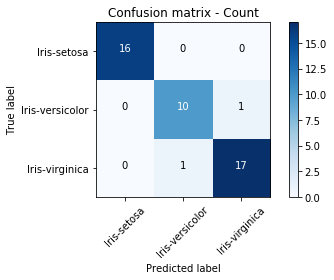

In [37]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix - Count')

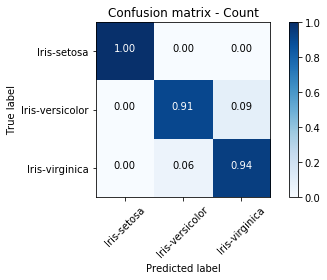

In [38]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix - Count',normalize=True)